# look this is a markdown cell

In [0]:
import numpy as np
import os
import re
import itertools
from matplotlib import pyplot as plt

def read_file(fname):
    (max_slices, n_types), type2size = [list(map(int, line[:-1].split(' '))) for line in open(fname).readlines()]
    type2size = np.array(type2size)

    # plt.bar(np.arange(n_types), type2size)
    # plt.title(f'{fname}, max_slices={max_slices}, n_types={n_types}')
    # plt.show()

    return (max_slices, n_types), type2size


inputs = [
    'a_example.in',
    'b_small.in',
    'c_medium.in',
    'd_quite_big.in',
    'e_also_big.in',
]

In [49]:
infile = inputs[3]
(max_slices, n_types), type2size = read_file(infile)
"""
type2size: given the type, returns the size
size_of_i = type2size[i]
"""

print('max_slices:', max_slices, 'ntypes:', n_types)
print('type2size:', type2size)

max_slices: 1000000000 ntypes: 2000
type2size: [   476    650   1257 ... 998294 999795 999867]


In [0]:
# the order will be a list of pizzas, it's length will be 
class Order(object):
    """
    contains info on an order

    the goal is to order as many slices as possible without
    """
    def __init__(self, infile, one_hot: np.array=None):
        """
        @param infile: str filename to read
        @param one_hot: a list of numbers corresponding to the number of pizzas for each type
            if 5 == one_hot[0], this means the order contains 5 orders of type 0.
        """
        self.infile = infile
        (self.max_slices, self.n_types), self.type2size = read_file(infile)

        self.one_hot = np.array(one_hot, dtype=int) if one_hot is not None \
            else np.zeros(self.n_types, dtype=int)
        
        if len(self.one_hot) != self.n_types:
            raise Exception('order_list must be same length of self.n_types')
        self.n_slices = 0
    
    def count_slices(self) -> int:
        #TODO: this indexing can be optimized, see numpy
        return sum([self.type2size[i] * v for i, v in enumerate(self.one_hot)])

    def score(self, one_hot=None) -> int:
        """
        @returns the score for the order (number of slices) -1 if invalid
        """
        if one_hot is None:
            one_hot = self.one_hot

        n_slices = self.count_slices()
        if n_slices > self.max_slices or (one_hot>1).sum():
            # print(f'INVALID: n_slices:({n_slices}) > max_slices:({max_slices})')
            return n_slices - self.max_slices
        return n_slices
    def percent_score(self) -> float:
        return self.score()/self.max_slices*100.0
    
    def try_add_pizza(self, i) -> bool:
        """"""
        if self._can_add_pizza(i):
            self.one_hot[i] = 1
            self.n_slices += self.type2size[i]
            return True
        return False

    def _can_add_pizza(self, i) -> bool:
        return self.one_hot[i] != 1 and (self.max_slices - self.type2size[i] > self.n_slices)

    def add_pizza(self, i):
        """adds pizza to the order and accumulates the size"""
        if self.one_hot[i] == 1:
            raise Exception(f"can't add more than 1 pizza of each type."
                f"type {i} already existed in the order.")
        self.one_hot[i] = 1
        self.n_slices += self.type2size[i]
    
    def remove_pizza(self, i):
        if self.one_hot[i] == 0:
            raise Exception(f"can't remove a pizza that doesn't exist."
                f"type {i} didn't already existed in the order.")
        self.one_hot[i] = 0
        self.n_slices -= self.type2size[i]

    # bonus functions...

    def plot(self):
        plt.bar(np.where(self.one_hot!=1)[0], self.type2size[self.one_hot!=1], label='unused')
        plt.bar(np.where(self.one_hot==1)[0], self.type2size[self.one_hot==1], label='used')
        plt.title(f'"{self.infile}", max_slices={self.max_slices}, n_types={self.n_types}')
        plt.legend()
        return plt.show()

    def get_output_str(self) -> str:
        out_str = str(self.one_hot.sum()) + '\n'
        pizzas = np.where(self.one_hot==1)[0]
        out_str += ' '.join(map(str, pizzas))
        return out_str
    
    def write_output(self):
        out_fname = re.sub('.in$', '.out', self.infile)
        os.makedirs('output', exist_ok=True)

        with open(os.path.join('output', out_fname), 'w') as file:
            file.write(self.get_output_str())
    
    def __repr__(self):
        return str('Order("{}",\tscore={:.6f}%({}/{}), {}'.format(
             self.infile, self.percent_score(), self.score(), self.max_slices, np.where(self.one_hot==1)[0]
        ))


Simple greedy approaches

We just sort and start from the largest

```algorithm

```

In [0]:
def greedy1(infile):
    order = Order(infile)
    # i: index of pizza
    for i, size in reversed(list(zip(np.argsort(order.type2size), order.type2size))):
        if order.max_slices - order.type2size[i] > order.count_slices():
            order.one_hot[i] = 1
    
    print(order)
    order.plot()
    return order


def greedy2(infile):
    """same as greedy1 but accumulates slices instead of counting everytime
    (much faster)
    """
    order = Order(infile)
    # i: index of pizza
    for i, size in reversed(list(zip(np.argsort(order.type2size), order.type2size))):
        if order.max_slices - order.type2size[i] > order.n_slices:
            order.one_hot[i] = 1
            order.n_slices += order.type2size[i]
            
    print(order)
    order.plot()
    return order

def greedy3(infile):
    """same as greedy1 but accumulates slices instead of counting everytime
    (much faster)
    """
    order = Order(infile)
    # i: index of pizza
    for i, size in reversed(list(zip(np.argsort(order.type2size), order.type2size))):
       order.try_add_pizza(i)
    
    print(order)
    order.plot()
    return order


def improve_order(order, iterations=300):
    raise NotImplementedError()
    return order

In [62]:
!pip install line_profiler -q
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [59]:
r = %lprun -r -f greedy1 greedy1('d_quite_big.in')
r.print_stats()

Order("d_quite_big.in",	score=99.999972%(999999725/1000000000), [  17  189  190 ... 1997 1998 1999]
Timer unit: 1e-06 s

Total time: 2.50081 s
File: <ipython-input-57-312430b3a3ce>
Function: greedy1 at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def greedy1(infile):
     2         1       3157.0   3157.0      0.1      order = Order(infile)
     3                                               # i: index of pizza
     4      2001       3192.0      1.6      0.1      for i, size in reversed(list(zip(np.argsort(order.type2size), order.type2size))):
     5      2000    2486231.0   1243.1     99.4          if order.max_slices - order.type2size[i] > order.count_slices():
     6      1812       3910.0      2.2      0.2              order.one_hot[i] = 1
     7         1       4320.0   4320.0      0.2      print(order)
     8         1          2.0      2.0      0.0      return order



Order("d_quite_big.in",	score=99.999972%(999999725/1000000000), [  17  189  190 ... 1997 1998 1999]


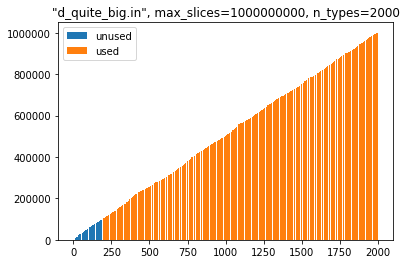

Timer unit: 1e-06 s

Total time: 7.90067 s
File: <ipython-input-61-54cf0fa7aff2>
Function: greedy2 at line 13

Line #      Hits         Time  Per Hit   % Time  Line Contents
    13                                           def greedy2(infile):
    14                                               """same as greedy1 but accumulates slices instead of counting everytime
    15                                               (much faster)
    16                                               """
    17         1       2212.0   2212.0      0.0      order = Order(infile)
    18                                               # i: index of pizza
    19      2001       1624.0      0.8      0.0      for i, size in reversed(list(zip(np.argsort(order.type2size), order.type2size))):
    20      2000       2043.0      1.0      0.0          if order.max_slices - order.type2size[i] > order.n_slices:
    21      1812       1028.0      0.6      0.0              order.one_hot[i] = 1
    22      1812       155

In [63]:
r = %lprun -r -f greedy2 greedy2('d_quite_big.in')
r.print_stats()

Order("d_quite_big.in",	score=99.999972%(999999725/1000000000), [  17  189  190 ... 1997 1998 1999]


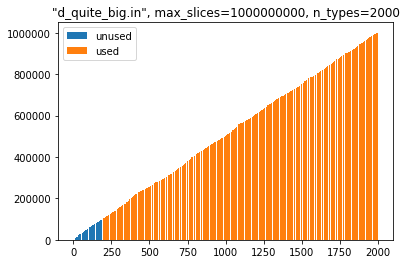

Timer unit: 1e-06 s

Total time: 8.16266 s
File: <ipython-input-61-54cf0fa7aff2>
Function: greedy3 at line 28

Line #      Hits         Time  Per Hit   % Time  Line Contents
    28                                           def greedy3(infile):
    29                                               """same as greedy1 but accumulates slices instead of counting everytime
    30                                               (much faster)
    31                                               """
    32         1       1454.0   1454.0      0.0      order = Order(infile)
    33                                               # i: index of pizza
    34      2001     294156.0    147.0      3.6      for i, size in reversed(list(zip(np.argsort(order.type2size), order.type2size))):
    35      2000       6591.0      3.3      0.1         order.try_add_pizza(i)
    36                                               
    37         1       3927.0   3927.0      0.0      print(order)
    38         1    78565

In [64]:
r = %lprun -r -f greedy3 greedy3('d_quite_big.in')
r.print_stats()

Order("a_example.in",	score=94.117647%(16/17), [0 2 3]


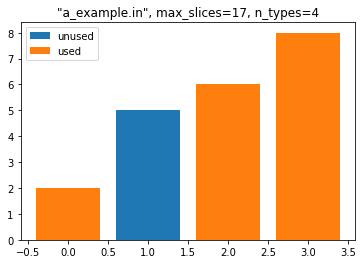

Order("b_small.in",	score=99.000000%(99/100), [0 9]


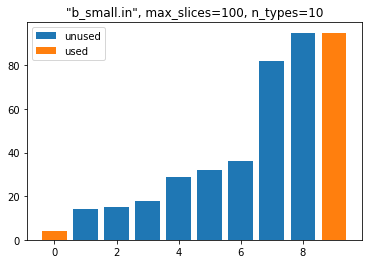

Order("c_medium.in",	score=99.888889%(4495/4500), [ 4 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]


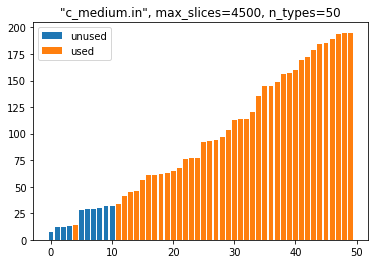

Order("d_quite_big.in",	score=99.999972%(999999725/1000000000), [  17  189  190 ... 1997 1998 1999]


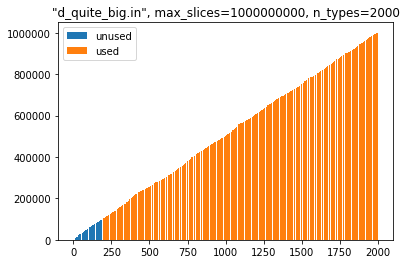

Order("e_also_big.in",	score=99.999997%(504999983/505000000), [ 266 5730 5731 ... 9997 9998 9999]


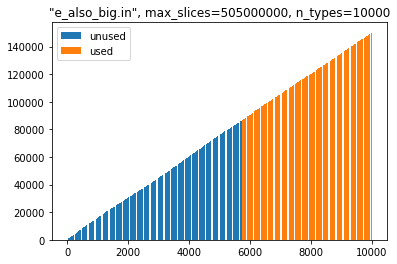

In [65]:
for input in inputs:
    order = greedy3(input)
    order.write_output()

In [0]:
# import numpy as np
# from scipy.optimize import minimize


# def rosen(x):
#     """The Rosenbrock function"""
#     return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)


# x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])
# res = minimize(rosen, x0, method='nelder-mead',
#                options={'xatol': 1e-8, 'disp': True})